# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [2]:
#Your code here
df = pd.read_csv("homepage_actions.csv")
df

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
...,...,...,...,...
8183,2017-01-18 09:11:41.984113,192060,experiment,view
8184,2017-01-18 09:42:12.844575,755912,experiment,view
8185,2017-01-18 10:01:09.026482,458115,experiment,view
8186,2017-01-18 10:08:51.588469,505451,control,view


In [28]:
#Everyone who clicked also viewed previously

df[df.id.isin(df[df.action=='click'].id)].action

7        view
8       click
11       view
12      click
14       view
        ...  
8167    click
8179     view
8180    click
8181     view
8182    click
Name: action, Length: 3720, dtype: object

In [27]:
# No intersection between experimental and control groups

exp = df[df.group == 'experiment']
ctrl = df[df.group == 'control']

intersection = set(exp.id.unique()).intersection(set(ctrl.id.unique()))
intersection

set()

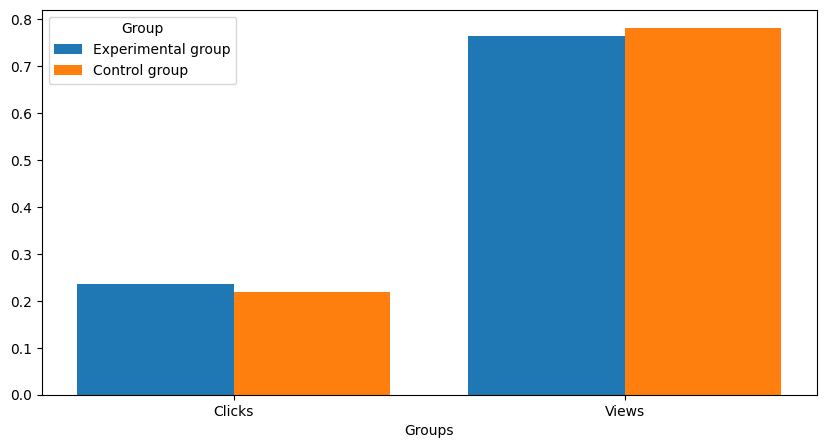

In [6]:
groups = [exp, ctrl]

clicks = [len(x[x.action == 'click'])/len(x) for x in groups]
views = [len(x[x.action == 'view'])/len(x) for x in groups]

experimental = [clicks[0], views[0]]
control = [clicks[1], views[1]]

fig, ax = plt.subplots(figsize=(10,5))

x = ["Clicks", "Views"]
x_axis = np.arange(len(x))

plt.xticks(x_axis, x)
plt.xlabel("Groups")

ax.bar(x_axis-0.2, experimental, 0.4, label="Experimental group")
ax.bar(x_axis+0.2, control, 0.4, label="Control group")
ax.legend(title="Group");

In [9]:
df['hour'] = df.timestamp.map(lambda x: int(x[10:13]))
hours = sorted(df.hour.unique())

experimental_hour_clicks = []
experimental_hour_views = []
control_hour_clicks = []
control_hour_views = []

for hour in hours:
    temp = df[(df["hour"] == hour) & (df["group"] == "experiment")]
    experimental_hour_clicks.append(len(temp[temp["action"] == "click"])/len(temp))
    experimental_hour_views.append(len(temp[temp["action"] == "view"])/len(temp))
    
    temp = df[(df["hour"] == hour) & (df["group"] == "control")]
    control_hour_clicks.append(len(temp[temp["action"] == "click"])/len(temp))
    control_hour_views.append(len(temp[temp["action"] == "view"])/len(temp))

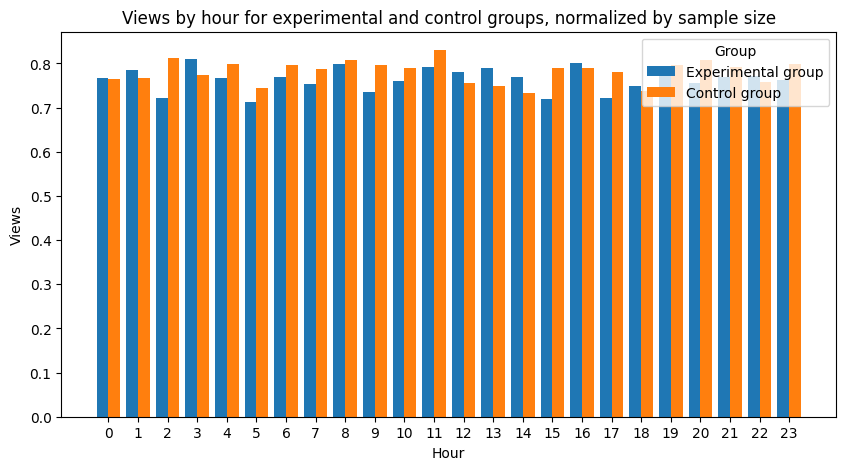

In [13]:
fig, ax = plt.subplots(figsize=(10,5))

x = hours
x_axis = np.arange(len(x))

plt.xticks(x_axis, x)
plt.xlabel("Hour")
plt.ylabel("Views")

ax.bar(x_axis-0.2, experimental_hour_views, 0.4, label="Experimental group")
ax.bar(x_axis+0.2, control_hour_views, 0.4, label="Control group")

ax.set_title("Views by hour for experimental and control groups, normalized by sample size")
ax.legend(title="Group");

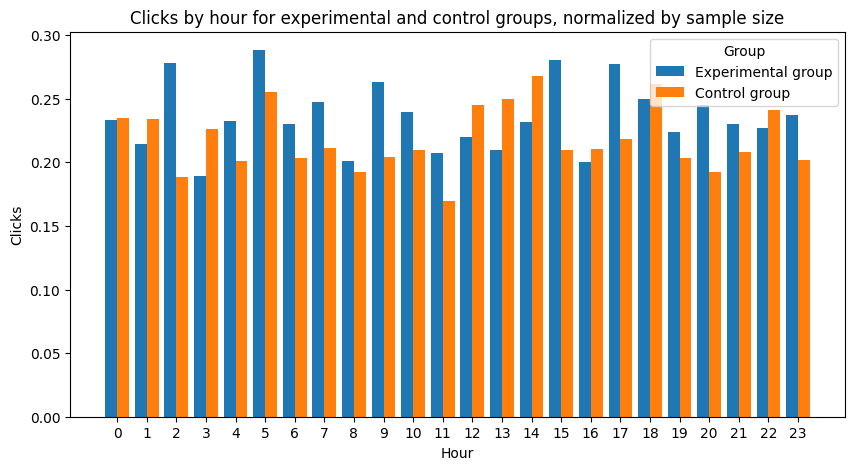

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

x = hours
x_axis = np.arange(len(x))

plt.xticks(x_axis, x)
plt.xlabel("Hour")
plt.ylabel("Clicks")

ax.bar(x_axis-0.2, experimental_hour_clicks, 0.4, label="Experimental group")
ax.bar(x_axis+0.2, control_hour_clicks, 0.4, label="Control group")

ax.set_title("Clicks by hour for experimental and control groups, normalized by sample size")
ax.legend(title="Group");

In [12]:
print(f"Experiment sample size: {len(exp.id.unique())}")
print(f"Control sample size: {len(ctrl.id.unique())}")

Experiment sample size: 2996
Control sample size: 3332


In [20]:
# Absolutely no visually detectable consistent difference in clicks or views.
# However, we'll see if a statistical test bears that out.

## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [99]:
#Your code here

# What really matters are the clicks, not the views
# I will divide our dataset into experimental and control clicks

exp_sample = df[(df.group == "experiment") & (df.action == "click")]
ctrl_sample = df[(df.group == "control") & (df.action == "click")]

n1 = len(exp.id.unique())
n2 = len(ctrl.id.unique())

In [92]:
"""
Null hypothesis: rate of clicks in experimental group not greater than that of the control group.
Alternative hypotheseis: rate of clicks in experimental group is greater than that of the control group.
"""

'\nNull hypothesis: rate of clicks in experimental group not greater than that of the control group.\nAlternative hypotheseis: rate of clicks in experimental group is greater than that of the control group.\n'

In [97]:
# Generate data that has 0s for people who viewed but didn't click and 1s for people who viewed and clicked

exp_ttest_data = np.concatenate((np.ones(len(exp_sample)), np.zeros(n1-len(exp_sample))))
ctrl_ttest_data = np.concatenate((np.ones(len(ctrl_sample)), np.zeros(n2-len(ctrl_sample))))


# Conduct one-sided Welch's t-test

stats.ttest_ind(exp_ttest_data, ctrl_ttest_data, equal_var=False, alternative="greater")

Ttest_indResult(statistic=2.615440020788211, pvalue=0.004466402814337102)

In [98]:
"""
The two-sided Welch's t-test gives a p-value that is lower than 0.05.
We can confidently reject the null hypothesis.
"""

"\nThe two-sided Welch's t-test gives a p-value that is lower than 0.05.\nWe can confidently reject the null hypothesis.\n"

## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [125]:
#Your code here

expected_click_rate = len(ctrl_sample)/n2
expected_clicks = n1*expected_click_rate

### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [122]:
#Your code here

actual_clicks = len(exp_sample)
actual_click_rate = len(exp_sample)/n1

variance = n2*(expected_click_rate*(1-expected_click_rate))
std = np.sqrt(variance)

deviation = (actual_clicks-expected_clicks)/std
deviation

3.4729643112857396

### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [136]:
#Your code here
stats.norm.sf(deviation)

0.00025737189895806245

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: **Both p-values yielded are very small, although the latter is about an order of magnitude smaller
than my p-value. This is not unexpected though, since my esimate came from a t-test, and the other estimate came from a z-test. T-distributions have fatter tails than z-distributions, which explains why my p-value came out larger.**

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.